In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm

from metpy import calc as mpcalc
from metpy.units import units

In [2]:
warnings.filterwarnings('ignore')

In [3]:
ISCCP_dir = '/w2-data/willytsai/ISCCP/hgg/'
TRMM_dir = '/w2-data2/willytsai/TRMM_3hr/TRMM/'
MERRA2_dir = '/w2-data2/willytsai/MERRA2/'
MERRA2_3d_dir = '/w2-data/willytsai/'
ERA5_dir = '/w2-data/willytsai/ERA5/'
Gridsat_dir = '/w2-data/willytsai/gridsat_BT/remap_0.25deg/'
fig_dir = '/w2-data/willytsai/ISCCP/fig/'

In [53]:
def remove_diurnal_1D(data_all):
    'remove diurnal cycle in the time series [N,time], N cases'
    tmp_re = np.copy(data_all)
    NT = data_all.shape[1]
    
    for n in range(data_all.shape[0]):
        tmp = np.fft.fft(data_all[n,:]) # 49
        freqs = np.array(range(NT))   # This gets the left end correct
        reversed_freqs = freqs[::-1]  # Reverse the array 
        reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
        freqs = reversed_freqs[::-1]  # reverse it back 
        tmp[np.where(freqs==6)] = 0 # remove diurnal cycle, 6 cycles for 6 days
        tmp[np.where(freqs==12)] = 0 # remove half-day cycle
        tmp_re[n,:] = np.fft.ifft(tmp) # reconstructed time-series                   
    
    return tmp_re

In [64]:
def remove_diurnal_2D(data_all):
    'remove diurnal cycle in the time series [N,time,lev], N cases'
    
    tmp_re = np.copy(data_all)
    NT = data_all.shape[1]
    
    for n in range(data_all.shape[0]):
        for k in range(data_all.shape[2]):
            tmp = np.fft.fft(data_all[n,:,k]) # 49
            freqs = np.array(range(NT))   # This gets the left end correct
            reversed_freqs = freqs[::-1]  # Reverse the array 
            reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
            freqs = reversed_freqs[::-1]  # reverse it back 
            tmp[np.where(freqs==6)] = 0 # remove diurnal cycle, 6 cycles for 6 days
            tmp[np.where(freqs==12)] = 0 # remove half-day cycle
            tmp[np.where(freqs==11)] = 0 # remove half-day cycle
            tmp[np.where(freqs==10)] = 0 # remove half-day cycle
            tmp_re[n,:,k] = np.fft.ifft(tmp) # reconstructed time-series                   
    
    return tmp_re

In [65]:
# load data
os.chdir('/w2-data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018.dat'))

In [66]:
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]

In [67]:
os.chdir('/w2-data/willytsai/TQUV_3hr/')
files = glob('*.nc')
lev = xr.open_dataset(files[0]).T.lev # MERRA2 standard level 
del files
os.chdir('/w2-data/willytsai/Cloudfrac_3hr/')
lev_m = np.loadtxt('model_lev.txt')[:,1]# MERRA2 model level, 58 levs [72-15]

In [68]:
os.chdir('/w2-data/willytsai/ISCCP')
omega_all = np.load('omega_all.mat.npy')
prec_all = np.load('prec_all.mat.npy')
cldamt_cu_all = np.load('cldamt_cu_all.mat.npy')
cldamt_st_all = np.load('cldamt_st_all.mat.npy')
cldamt_dc_all = np.load('cldamt_dc_all.mat.npy')


omega_all = remove_diurnal_2D(omega_all)
prec_all = remove_diurnal_1D(prec_all)
cldamt_cu_all = remove_diurnal_1D(cldamt_cu_all)
cldamt_dc_all = remove_diurnal_1D(cldamt_dc_all)
cldamt_st_all = remove_diurnal_1D(cldamt_st_all)

In [69]:
time_event = np.asarray(time_event)
lat_event = lat_event
lon_event = lon_event

In [70]:
lat_cen = np.arange(-5,10,5)
lon_cen = np.arange(-175,180,5)
idx_record = [] # idx list for final events

for lat in lat_cen:
    for lon in lon_cen:
        idx = np.where(lat_event==lat)[0]
        idy = np.where(lon_event==lon)[0]
        idx_org = np.intersect1d(idx,idy)
        
        time_frame = time_event[idx_org]
        for i,idx in enumerate(idx_org):
            if i == 0:
                if (time_frame[i+1]-time_frame[i]).days >= 6:
                    idx_record.append(idx)
            elif i == len(idx_org)-1:
                if (time_frame[i]-time_frame[i-1]).days >= 6:
                    idx_record.append(idx)
            else:
                if (time_frame[i+1]-time_frame[i]).days >= 6 and \
                   (time_frame[i]-time_frame[i-1]).days >= 6:
                    idx_record.append(idx)            

In [71]:
idx_rm = np.array(idx_record) # new idx with removal overlapping

In [72]:
time_event = time_event[idx_rm]
lat_event = lat_event[idx_rm]
lon_event = lon_event[idx_rm]
omega_all = omega_all[idx_rm]

#### vertical mode decomposition of omega

In [384]:
omega_test.shape[0]

49

In [127]:
ps = 1000
ptp = 100
p = lev[:25]
fbc1 = -np.sin(1*np.pi*(p-ptp)/(ps-ptp)) # prescribed first mode
fbc2 = np.sin(2*np.pi*(p-ptp)/(ps-ptp)) # prescribed second mode 
fshl = -np.sin(np.pi*(p-850)/(ps-850)); fshl[6:] = 0 # prescribed shallow mode 

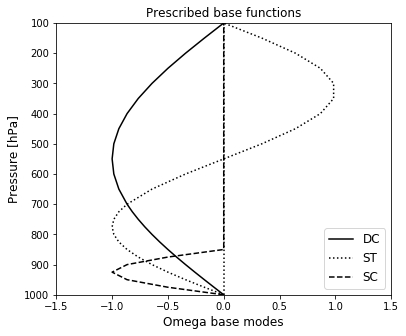

In [390]:
fig = plt.figure(figsize=(6,5))

plt.plot(fbc1,p,'k')
plt.plot(fbc2,p,'k',linestyle='dotted')
plt.plot(fshl,p,'--k')
plt.ylim([1000,100]);plt.xlim([-1.5,1.5])
plt.legend(['DC','ST','SC'],fontsize=12,loc=4)
plt.vlines(x=0,ymax=1000,ymin=100,linestyles='dotted')
plt.xlabel('Omega base modes',fontsize=12);plt.ylabel('Pressure [hPa]',fontsize=12)
plt.title('Prescribed base functions')
fig.savefig('/w2-data/willytsai/ISCCP/fig/basefunction_omega.pdf',dpi=200,bbox_inches='tight')

In [367]:
# basic functions/modes
fbc_mtx = np.stack((fbc1,fbc2,fshl),axis=0)
fbc_mtx = np.matrix(fbc_mtx)

omega_test = np.nanmean(omega_all,axis=0)

m_time = np.zeros((3,49))
omega_rcst =  # reconstructed profile by three modes 
for t in range(49):
    omega_mtx = np.matrix((omega_test[t,:25]-omega_bg[:25])*3600/100)
    m_mtx = (fbc_mtx*fbc_mtx.T).I*(fbc_mtx*omega_mtx.T) # regression coefficient    
    m_time[:,t] = m_mtx.A.T

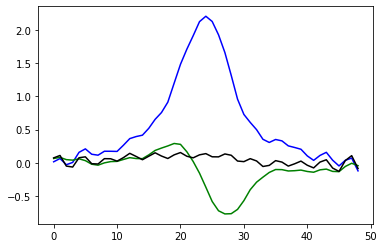

In [368]:
plt.plot(m_time[0,:],'b')
plt.plot(m_time[1,:],'g')
plt.plot(m_time[2,:],'k')

In [320]:
m_mtx = (fbc_mtx*fbc_mtx.T).I*(fbc_mtx*omega_mtx.T) # regression coefficient
omega_comp = m_mtx.T*fbc_mtx

(-10, 10)

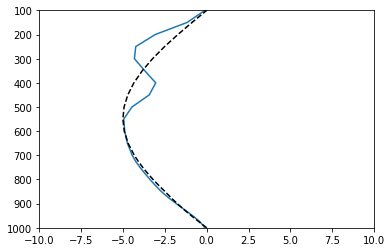

In [321]:
plt.plot(omega_mtx.A[0],p)
plt.plot(omega_comp.A[0],p,'--k')
plt.ylim([1000,100]);plt.xlim([-10,10])

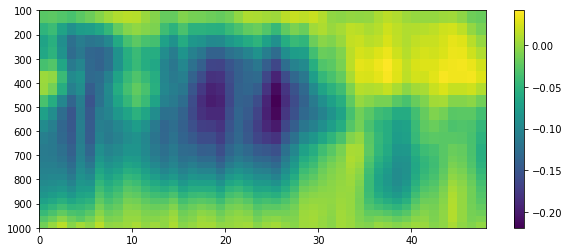

In [322]:
fig = plt.figure(figsize=(10,4))
plt.pcolor(np.arange(49),lev,omega_test.T)
plt.ylim([1000,100]);plt.colorbar()

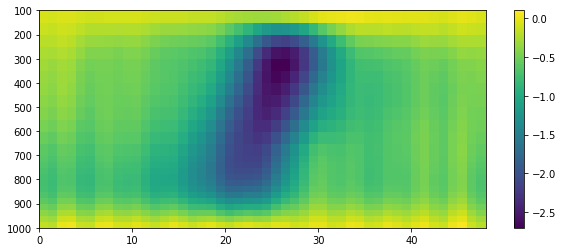

In [90]:
fig = plt.figure(figsize=(10,4))
plt.pcolor(np.arange(49),lev,0.01*3600*np.nanmean(omega_all,axis=0).T)
plt.ylim([1000,100]);plt.colorbar()

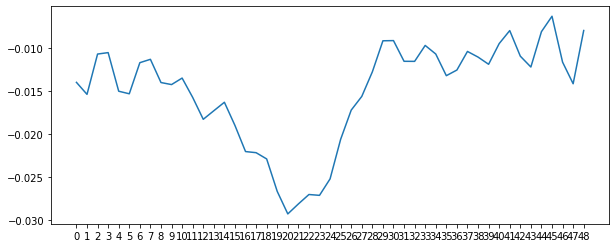

In [78]:
fig = plt.figure(figsize=(10,4))
plt.plot(np.nanmean(omega_all[:,:,3],axis=0))
plt.xticks(np.arange(49));plt.show()

In [87]:
omega_allmn = np.nanmean(omega_all,axis=0)
omega_bg = np.nanmean(np.concatenate((omega_allmn[:4,:],omega_allmn[-4:,:])),axis=0)